In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras.layers import merge
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D, ZeroPadding2D, AveragePooling2D
from keras.layers.core import Dense, Activation, Flatten, Reshape, Lambda
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.layers import Input
from keras.optimizers import SGD, adam
import scipy.io as sio
from keras import layers
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau
from keras import optimizers
from sklearn.metrics import confusion_matrix
import itertools

Using TensorFlow backend.


In [2]:
intra_class_psk = ['BPSK','QPSK','8PSK']
inp_p = np.load('.\\dataset\\recognise\\psk_data.npy')
label_p = sio.loadmat('.\\dataset\\recognise\\psk_label_onehot.mat')
print(inp_p.shape)
print(label_p['intra_class'].shape)

(60000, 2, 1024)
(60000, 3)


In [3]:
dr = 0.2
def get_psk_model():
    #init
    inp = Input([2, 1024])
    out = Reshape([2, 1024, 1])(inp)
    #part1
    out = Conv2D(80, kernel_size=(1, 4), strides=1, 
                        data_format='channels_last', padding='same',
                        activation=None, init='he_normal')(out)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
    out = layers.Dropout(dr)(out)
    
    out = MaxPooling2D(pool_size=(1,2),padding='same')(out)
    
    out = Conv2D(128, kernel_size=(2, 3), strides=1, 
                        data_format='channels_last', padding='valid',
                        activation=None, init='he_normal')(out)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
    out = layers.Dropout(dr)(out)
    #part3 
    out = layers.GlobalAveragePooling2D()(out)
    out = layers.Dense(64,init='he_normal')(out)
    
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
    out = layers.Dropout(dr)(out)
     #last
    out = Dense(len(intra_class_psk), activation='softmax')(out)
   

    model = Model(inp, out)
    return model
it_psk_model = get_psk_model()
it_psk_model.summary()

d:\python35\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(80, kernel_initializer="he_normal", activation=None, kernel_size=(1, 4), strides=1, data_format="channels_last", padding="same")`
  if __name__ == '__main__':
d:\python35\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, kernel_initializer="he_normal", activation=None, kernel_size=(2, 3), strides=1, data_format="channels_last", padding="valid")`
d:\python35\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(64, kernel_initializer="he_normal")`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2, 1024)           0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 2, 1024, 1)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 2, 1024, 80)       400       
_________________________________________________________________
batch_normalization_1 (Batch (None, 2, 1024, 80)       320       
_________________________________________________________________
activation_1 (Activation)    (None, 2, 1024, 80)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 1024, 80)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 512, 80)        0         
__________

In [4]:
# split trainingset and val set
X_train, X_val, Y_train, Y_val = train_test_split(inp_p, label_p['intra_class'],
                                                  test_size = 0.1, random_state=1)
print(X_train.shape)
print(X_val.shape)

(54000, 2, 1024)
(6000, 2, 1024)


In [5]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=4, 
                                            verbose=1, 
                                            factor=0.1, 
                                            min_lr=1e-6,
                                            mode='min')

In [6]:
it_psk_model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08),
              metrics=['accuracy'])
history = it_psk_model.fit(X_train, Y_train,
                  epochs=80,
                  batch_size=128,
                  verbose=1,
                  #validation_data=None)
                  validation_data=(X_val, Y_val),
                  callbacks=[learning_rate_reduction])  

Train on 54000 samples, validate on 6000 samples
Epoch 1/80
54000/54000 [==============================] - 43s - loss: 0.4347 - acc: 0.8111 - val_loss: 0.3497 - val_acc: 0.8720
Epoch 2/80
54000/54000 [==============================] - 40s - loss: 0.2505 - acc: 0.9022 - val_loss: 0.7205 - val_acc: 0.6912
Epoch 3/80
54000/54000 [==============================] - 40s - loss: 0.1719 - acc: 0.9346 - val_loss: 0.4664 - val_acc: 0.7678
Epoch 4/80
54000/54000 [==============================] - 40s - loss: 0.1446 - acc: 0.9427 - val_loss: 0.2984 - val_acc: 0.8640
Epoch 5/80
54000/54000 [==============================] - 40s - loss: 0.1278 - acc: 0.9487 - val_loss: 0.2809 - val_acc: 0.8695
Epoch 6/80
54000/54000 [==============================] - 40s - loss: 0.1177 - acc: 0.9526 - val_loss: 0.2046 - val_acc: 0.9122
Epoch 7/80
54000/54000 [==============================] - 40s - loss: 0.1086 - acc: 0.9545 - val_loss: 0.1683 - val_acc: 0.9248
Epoch 8/80
54000/54000 [==============================]

54000/54000 [==============================] - 39s - loss: 0.0703 - acc: 0.9703 - val_loss: 0.1231 - val_acc: 0.9407
Epoch 61/80
54000/54000 [==============================] - 39s - loss: 0.0727 - acc: 0.9688 - val_loss: 0.1217 - val_acc: 0.9417
Epoch 62/80
54000/54000 [==============================] - 39s - loss: 0.0715 - acc: 0.9698 - val_loss: 0.1247 - val_acc: 0.9400
Epoch 63/80
54000/54000 [==============================] - 39s - loss: 0.0710 - acc: 0.9695 - val_loss: 0.1189 - val_acc: 0.9438
Epoch 64/80
54000/54000 [==============================] - 39s - loss: 0.0705 - acc: 0.9702 - val_loss: 0.1260 - val_acc: 0.9392
Epoch 65/80
54000/54000 [==============================] - 39s - loss: 0.0707 - acc: 0.9701 - val_loss: 0.1215 - val_acc: 0.9422
Epoch 66/80
54000/54000 [==============================] - 39s - loss: 0.0707 - acc: 0.9697 - val_loss: 0.1249 - val_acc: 0.9395
Epoch 67/80
54000/54000 [==============================] - 39s - loss: 0.0711 - acc: 0.9698 - val_loss: 0.119

In [7]:
it_psk_model.save_weights('.\\res\\Net_weight\\model_weights_intraclass_psk.h5')

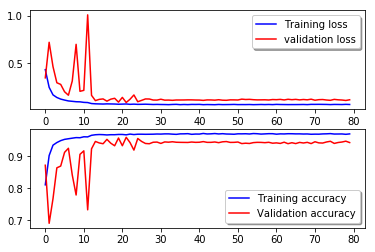

In [8]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

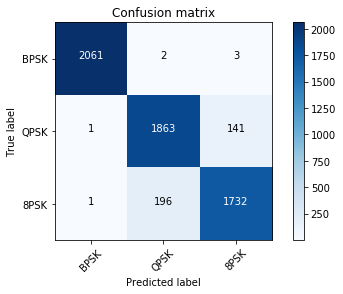

In [12]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(intra_class_psk))
    plt.xticks(tick_marks, intra_class_psk, rotation=45)
    plt.yticks(tick_marks, intra_class_psk)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = it_psk_model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, normalize=False,classes = range(3)) 